## 1. Setup & Imports

In [1]:
import pandas as pd
import numpy as np
import requests
import ipywidgets as widgets
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from etf_loader import load_etfs
from factor_engine import compute_factors
from screener_engine import create_scorecard
from performance_analyzer import analyze_tickers
from ipywidgets import Text, Button, VBox, Output, HTML

In [14]:
# Output widget to display results
out = Output()

# Input widget for keywords
search_input = Text(
    value='',
    placeholder='Type company or ETF name...',
    description='Search:',
    disabled=False
)

# Button to trigger search
search_button = Button(
    description='Search',
    button_style='info'
)

# Function to query Yahoo Finance autocomplete API
def search_yahoo(keyword):
    url = f'https://query1.finance.yahoo.com/v1/finance/search?q={keyword}'
    try:
        response = requests.get(url)
        data = response.json()
        quotes = data.get('quotes', [])
        results = []
        for q in quotes:
            results.append({
                "symbol": q.get("symbol", ""),
                "name": q.get("shortname", q.get("longname", "")),
                "type": q.get("quoteType", "")
            })
        return pd.DataFrame(results)
    except Exception as e:
        return pd.DataFrame([{"symbol": "", "name": f"Error: {e}", "type": ""}])

# Button click handler
def on_search_clicked(b):
    out.clear_output()
    keyword = search_input.value.strip()
    if keyword:
        df = search_yahoo(keyword)
        with out:
            if df.empty:
                print("No results found.")
            else:
                display(df)
    else:
        with out:
            print("Please type a search term.")

# Link button to function
search_button.on_click(on_search_clicked)

# Display in notebook
display(VBox([search_input, search_button, out]))


## 2. Parameters (user inputs)
Specify the tickers of the assets you want to examine.


In [2]:
TICKERS = [ "SPY", "QQQ", "URTH", "EEM", "GLD"]
PERIOD = "3y"    # e.g. '1y','3y','5y','max'
RISK_FREE = 0.015  # 1.5% as example
MAX_PLOT_TICKERS = 5  # limit for overplotting


## 3. Load data

In [3]:
etf_data = load_etfs(TICKERS, period=PERIOD, interval="1d")

# Quick check of which tickers succeeded
succeeded = [t for t in TICKERS if t in etf_data]
failed = [t for t in TICKERS if t not in etf_data]
print("Succeeded:", succeeded)
if failed:
    print("Failed:", failed)

# peek at one
for t in succeeded[:1]:
    print(t, etf_data[t]["prices"].head())


Downloading: SPY
Downloading: QQQ
Downloading: URTH
Downloading: EEM
Downloading: GLD
Succeeded: ['SPY', 'QQQ', 'URTH', 'EEM', 'GLD']
SPY Price        Adj Close       Close        High         Low        Open  \
Ticker             SPY         SPY         SPY         SPY         SPY   
Date                                                                     
2022-11-29  379.301788  395.230011  397.299988  393.299988  396.049988   
2022-11-30  391.249969  407.679993  407.679993  393.480011  395.489990   
2022-12-01  390.962158  407.380005  410.000000  404.750000  408.769989   
2022-12-02  390.511078  406.910004  407.859985  402.140015  402.250000   
2022-12-05  383.486023  399.589996  404.929993  398.170013  403.950012   

Price          Volume  
Ticker            SPY  
Date                   
2022-11-29   52310000  
2022-11-30  144566700  
2022-12-01   76398200  
2022-12-02   85342700  
2022-12-05   77289800  


## 4. Factor computation
Compute cross-sectional factor table


In [4]:
factor_df = compute_factors(etf_data)
print("Factor table:")
display(factor_df)

# Save
factor_df.to_csv("factor_table.csv", index=False)
print("Saved factor_table.csv")


Factor table:


,Ticker,Momentum,Growth,Value,Volatility,MaxDrawdown,Sentiment
0,EEM,0.255777,0.293117,0.967581,0.164380,-0.172924,0
1,GLD,0.461059,0.596543,0.438324,0.162244,-0.113474,0
2,QQQ,0.270546,0.222423,0.577754,0.204164,-0.227683,0
3,SPY,0.184675,0.151583,0.628075,0.156834,-0.187552,0
4,URTH,0.194530,0.176975,0.039832,0.145256,-0.169358,0


Saved factor_table.csv


## 5. Screener: scorecard (z-score normalization)
Create ranked scorecard from the factor table.


In [5]:
scorecard = create_scorecard(factor_df)
print("Scorecard:")
display(scorecard)
scorecard.to_csv("scorecard.csv", index=False)
print("Saved scorecard.csv")


Scorecard:


C:\Users\HP\Projects\etftool\screener_engine.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scorecard.rename(columns={


,Rank,Ticker,CompositeScore,Momentum,Growth,Value,Volatility,Sentiment,MaxDrawdown
0,1,GLD,0.831356,1.685506,1.707749,-0.273638,0.194408,0,-0.113474
1,2,EEM,0.238139,-0.157472,0.027627,1.300729,0.098546,0,-0.172924
2,3,SPY,-0.244358,-0.795813,-0.756075,0.290809,0.437195,0,-0.187552
3,4,QQQ,-0.389397,-0.024877,-0.363823,0.141121,-1.686966,0,-0.227683
4,5,URTH,-0.435739,-0.707343,-0.615477,-1.459021,0.956817,0,-0.169358


Saved scorecard.csv


## 6. Performance analysis (cumulative performance + metrics)
We will compute cumulative series and metrics for the tickers that have data.


In [6]:
plot_tickers = succeeded[:MAX_PLOT_TICKERS]
print("Computing performance for:", plot_tickers)

cum_df, metrics = analyze_tickers(plot_tickers, period=PERIOD, risk_free_rate=RISK_FREE)

print("Cumulative DataFrame (head):")
display(cum_df.head())

metrics_df = pd.DataFrame(metrics).T
metrics_df = metrics_df[["TotalReturn","AnnualReturn","AnnualVolatility","SharpeRatio"]]
# Format selected columns as percentages with 1 decimal
pct_cols = ["TotalReturn", "AnnualReturn", "AnnualVolatility"]

metrics_df[pct_cols] = metrics_df[pct_cols] * 100
metrics_df[pct_cols] = metrics_df[pct_cols].round(1)
metrics_df[pct_cols] = metrics_df[pct_cols].astype(str) + "%"

print("Metrics:")
display(metrics_df)

metrics_df.to_csv("performance_metrics.csv")
print("Saved performance_metrics.csv")


Computing performance for: ['SPY', 'QQQ', 'URTH', 'EEM', 'GLD']
Downloading: SPY
Downloading: QQQ
Downloading: URTH
Downloading: EEM
Downloading: GLD
Cumulative DataFrame (head):


,SPY,QQQ,URTH,EEM,GLD
Date,,,,,
2022-11-29,0.000000,0.000000,0.000000,0.000000,0.000000
2022-11-30,0.031501,0.045586,0.026955,0.028899,0.012782
2022-12-01,0.030742,0.046869,0.030335,0.025514,0.031402
2022-12-02,0.029553,0.042699,0.029179,0.029419,0.027838
2022-12-05,0.011032,0.025199,0.010853,0.017704,0.010201


Metrics:


,TotalReturn,AnnualReturn,AnnualVolatility,SharpeRatio
SPY,80.2%,21.0%,15.7%,1.240674
QQQ,124.9%,29.3%,20.4%,1.359232
URTH,73.2%,19.5%,14.5%,1.237297
EEM,52.4%,15.5%,16.4%,0.850234
GLD,138.4%,30.4%,16.2%,1.783746


Saved performance_metrics.csv


## 7. Plot cumulative performance (interactive Plotly)
Plot normalized cumulative returns from the `cum_df` DataFrame.


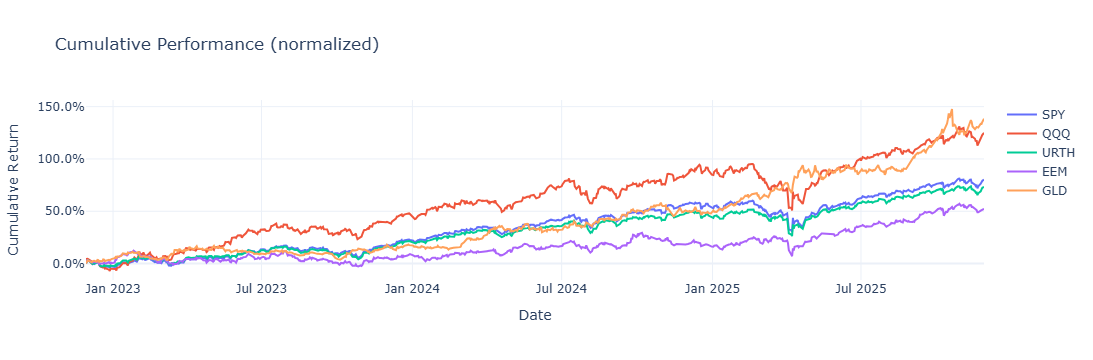

In [7]:
if not cum_df.empty:
    fig = go.Figure()
    for col in cum_df.columns:
        fig.add_trace(go.Scatter(x=cum_df.index, y=cum_df[col], mode='lines', name=col))
        fig.update_yaxes(tickformat=".1%", rangemode="tozero")
    fig.update_layout(title="Cumulative Performance (normalized)", xaxis_title="Date", yaxis_title="Cumulative Return", template='plotly_white')
    fig.show()
else:
    print("No cumulative data to plot")


## 8. Interactive single-ticker price & indicators (plotly)
Select one ticker (change the variable below) and display price + rolling vol and drawdown.


In [8]:
print(TICKERS)
SINGLE = input("Enter ticker to plot (e.g. VOO): ").strip().upper()
print(f"Selected: {SINGLE}")


['SPY', 'QQQ', 'URTH', 'EEM', 'GLD']


Enter ticker to plot (e.g. VOO):  QQQ


Selected: QQQ


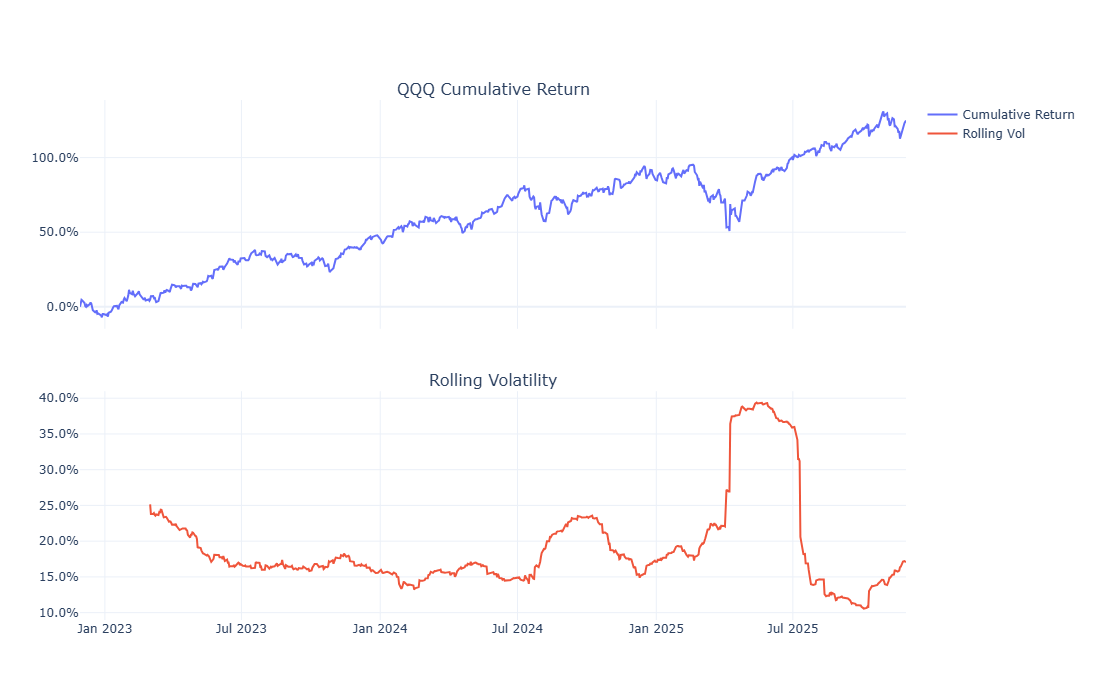

In [9]:
#SINGLE = plot_tickers[2] if plot_tickers else None
WINDOW = 63  # ~ quarterly rolling

if SINGLE:
    price = etf_data[SINGLE]["prices"].copy()

    # Flatten yfinance MultiIndex columns
    if isinstance(price.columns, pd.MultiIndex):
        price.columns = price.columns.get_level_values(0)

    price = price.dropna(subset=["Adj Close"])
    price['Returns'] = price['Adj Close'].pct_change()
    price['RollingVol'] = price['Returns'].rolling(WINDOW).std() * np.sqrt(252)

    # Cumulative return (in % form)
    cum = (1 + price['Returns'].fillna(0)).cumprod()
    cum = cum / cum.iloc[0] - 1  # now: decimal cumulative return

    # ------------------------------------------
    # Plot
    # ------------------------------------------
    fig = make_subplots(
        rows=2, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.12,
        subplot_titles=(f"{SINGLE} Cumulative Return", "Rolling Volatility")
    )

    # ---- 1) Cumulative return (top chart) ----
    fig.add_trace(
        go.Scatter(x=cum.index, y=cum, name="Cumulative Return"),
        row=1, col=1
    )

    fig.update_yaxes(tickformat=".1%", row=1, col=1)

    # ---- 2) Rolling volatility (bottom chart) ----
    fig.add_trace(
        go.Scatter(x=price.index, y=price['RollingVol'], name="Rolling Vol"),
        row=2, col=1
    )

    fig.update_yaxes(tickformat=".1%", row=2, col=1)

    fig.update_layout(
        height=700,
        template="plotly_white",
        hovermode="x unified"
    )

    fig.show()

else:
    print("No single ticker selected")


## 9. Visual summary charts (matplotlib)
Small static charts: factor bar chart, risk-return scatter.


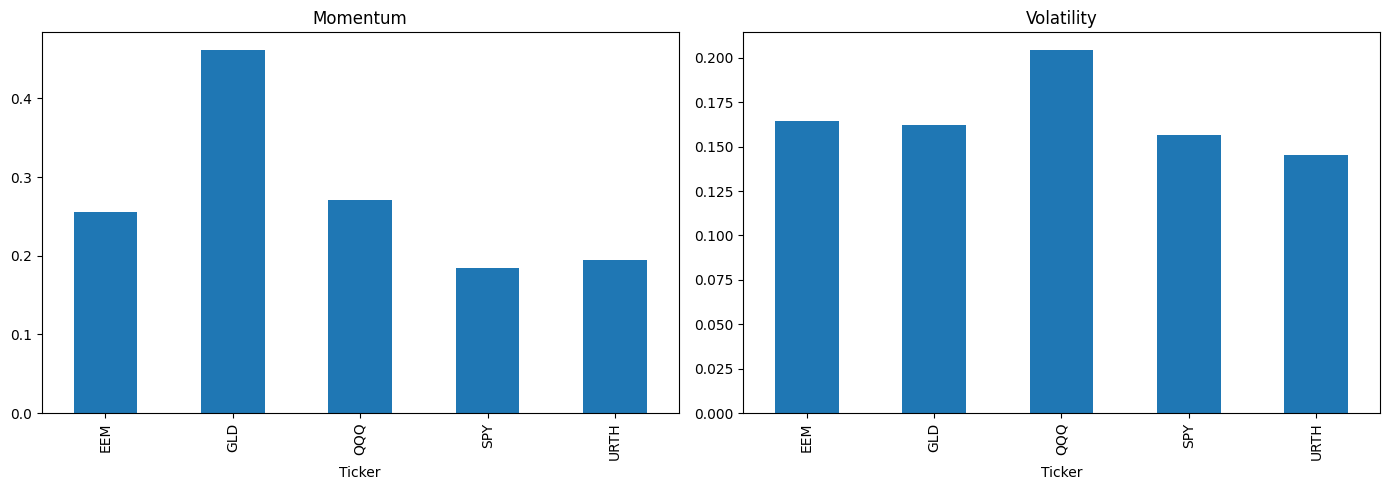

C:\Users\HP\AppData\Local\Temp\ipykernel_1100\755695647.py:17: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\HP\AppData\Local\Temp\ipykernel_1100\755695647.py:18: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



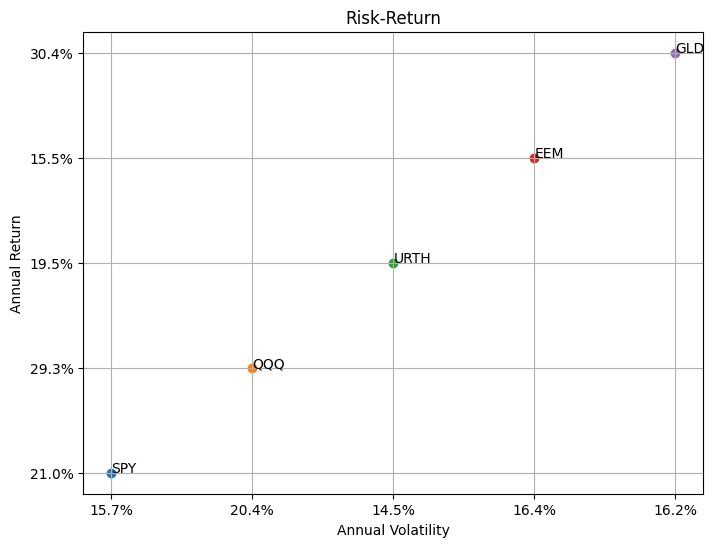

In [10]:
# Factor bar chart for Momentum and Volatility
if not factor_df.empty:
    fig, axes = plt.subplots(1,2, figsize=(14,5))
    factor_df.plot(kind='bar', x='Ticker', y='Momentum', ax=axes[0], legend=False)
    axes[0].set_title('Momentum')
    factor_df.plot(kind='bar', x='Ticker', y='Volatility', ax=axes[1], legend=False)
    axes[1].set_title('Volatility')
    plt.tight_layout()
    plt.show()

# Risk-return scatter
if not metrics_df.empty:
    plt.figure(figsize=(8,6))
    x = metrics_df['AnnualVolatility']
    y = metrics_df['AnnualReturn']
    for i, t in enumerate(metrics_df.index):
        plt.scatter(x[i], y[i])
        plt.text(x[i], y[i], t)
    plt.xlabel('Annual Volatility')
    plt.ylabel('Annual Return')
    plt.title('Risk-Return')
    plt.grid(True)
    plt.show()
else:
    print('No metrics to plot')


## 10. Export & wrap-up
Files saved earlier: `factor_table.csv`, `scorecard.csv`, `performance_metrics.csv`.
